#  Quick-start with Xylo-Audio v2

This notebook gives you an ultra-quick overview of taking a network from high-level Python simulation through to deployment on the Xylo-Audio v2 HDK

## Part I: Using the Xylo-Audio v2 SNN Core

### Step 1: Build a network in rockpool and convert it to a hardware configuration

In [1]:
# - Import the computational modules and combinators required for the networl
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual
import rockpool.devices.xylo.syns61201 as x
from rockpool.devices.xylo.syns61201 import xa2_devkit_utils as xu
from rockpool.transform import quantize_methods as q
from rockpool import TSEvent, TSContinuous

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Display images
from IPython.display import Image

# - Disable warnings
import warnings
warnings.filterwarnings('ignore')

from IPython import display

In [2]:
# - Define the size of the network layers
Nin = 2
Nhidden = 4
Nout = 2
dt = 1e-3

In [3]:
# - Define the network architecture using combinators and modules
net = Sequential(
    LinearTorch((Nin, Nhidden), has_bias = False),
    LIFTorch(Nhidden, dt = dt),
    
    Residual(
        LinearTorch((Nhidden, Nhidden), has_bias = False),
        LIFTorch(Nhidden, has_rec = True, threshold = 1., dt = dt),
    ),
    
    LinearTorch((Nhidden, Nout), has_bias = False),
    LIFTorch(Nout, dt = dt),
)
print(net)

# - Scale down recurrent weights for stability
# net[2][1].w_rec.data = net[2][1].w_rec / 10.

TorchSequential  with shape (2, 2) {
    LinearTorch '0_LinearTorch' with shape (2, 4)
    LIFTorch '1_LIFTorch' with shape (4, 4)
    TorchResidual '2_TorchResidual' with shape (4, 4) {
        LinearTorch '0_LinearTorch' with shape (4, 4)
        LIFTorch '1_LIFTorch' with shape (4, 4)
    }
    LinearTorch '3_LinearTorch' with shape (4, 2)
    LIFTorch '4_LIFTorch' with shape (2, 2)
}


In [4]:
# - Print its computational graph
print(net.as_graph())

GraphHolder "TorchSequential__140274037712736" with 2 input nodes -> 2 output nodes


In [5]:
# - Call the Xylo mapper on the extracted computational graph
spec = x.mapper(net.as_graph(),  weight_dtype='float', threshold_dtype='float', dash_dtype='float')

In [6]:
print(spec)

{'mapped_graph': GraphHolder "TorchSequential__140274037712736" with 2 input nodes -> 2 output nodes, 'weights_in': array([[ 0.7343877 , -0.39316231, -0.44816187,  0.71039516,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-1.2871033 , -0.46937197, -1.07198   ,  0.36067343,  0.        ,
         0.        ,  0.        ,  0.        ]]), 'weights_out': array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.19069742,  0.20018485],
       [ 0.67909682, -0.58289152],
       [ 0.79728281, -0.32970378],
       [ 1.17886066, -0.02250722]]), 'weights_rec': array([[ 0.        ,  0.        ,  0.        ,  0.        , -1.10508466,
         1.09192574, -0.77132285, -1.03136778],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.11368687,
         0.946657  , -0.27831113,  0.45472747],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.97648895,
        -1.15

In [7]:
# - Quantize the specification
spec.update(q.global_quantize(**spec))

In [8]:
print(spec)

{'mapped_graph': GraphHolder "TorchSequential__140274037712736" with 2 input nodes -> 2 output nodes, 'weights_in': array([[  72,  -39,  -44,   70,    0,    0,    0,    0],
       [-127,  -46, -106,   36,    0,    0,    0,    0]]), 'weights_out': array([[  0,   0],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [ 21,  22],
       [ 73, -63],
       [ 86, -36],
       [127,  -2]]), 'weights_rec': array([[   0,    0,    0,    0, -109,  108,  -76, -102],
       [   0,    0,    0,    0,   11,   93,  -27,   45],
       [   0,    0,    0,    0,   96, -113,  -87,  -46],
       [   0,    0,    0,    0,   82,  -67,   16,   56],
       [   0,    0,    0,    0,  104,    6,   53,  -20],
       [   0,    0,    0,    0,   50,   38,   37, -117],
       [   0,    0,    0,    0,   25,   97,  -29,   11],
       [   0,    0,    0,    0,   91,   12,  -55,   34]]), 'dash_mem': array([4, 4, 4, 4, 4, 4, 4, 4]), 'dash_mem_out': array([4, 4]), 'dash_syn': array([4, 4, 4, 4, 4, 4, 4, 4]), 'dash

In [ ]:
# # you can also try channel-wise quantization
# spec.update(q.channel_quantize(**spec))
# print(spec)

In [9]:
# - Use rockpool.devices.xylo.config_from_specification to convert it to a hardware configuration
config, is_valid, msg = x.config_from_specification(**spec)
if not is_valid:
    print(msg)

In [10]:
# - USe rockpool.devices.xylo.xylo_devkit_utils.find_xylo_a2_boards
xylo_hdk_nodes = xu.find_xylo_a2_boards()
print(xylo_hdk_nodes)

found_xylo = len(xylo_hdk_nodes) > 0

if not found_xylo:
    print('This tutorial requires a connected Xylo HDK to demonstrate.')
else:
    db = xylo_hdk_nodes[0]

In [11]:
# - Use rockpool.devices.xylo.XyloSamna to deploy to the HDK
if found_xylo:
    modSamna = x.XyloSamna(db, config, dt = dt)
    print(modSamna)

XyloSamna  with shape (2, 8, 2)


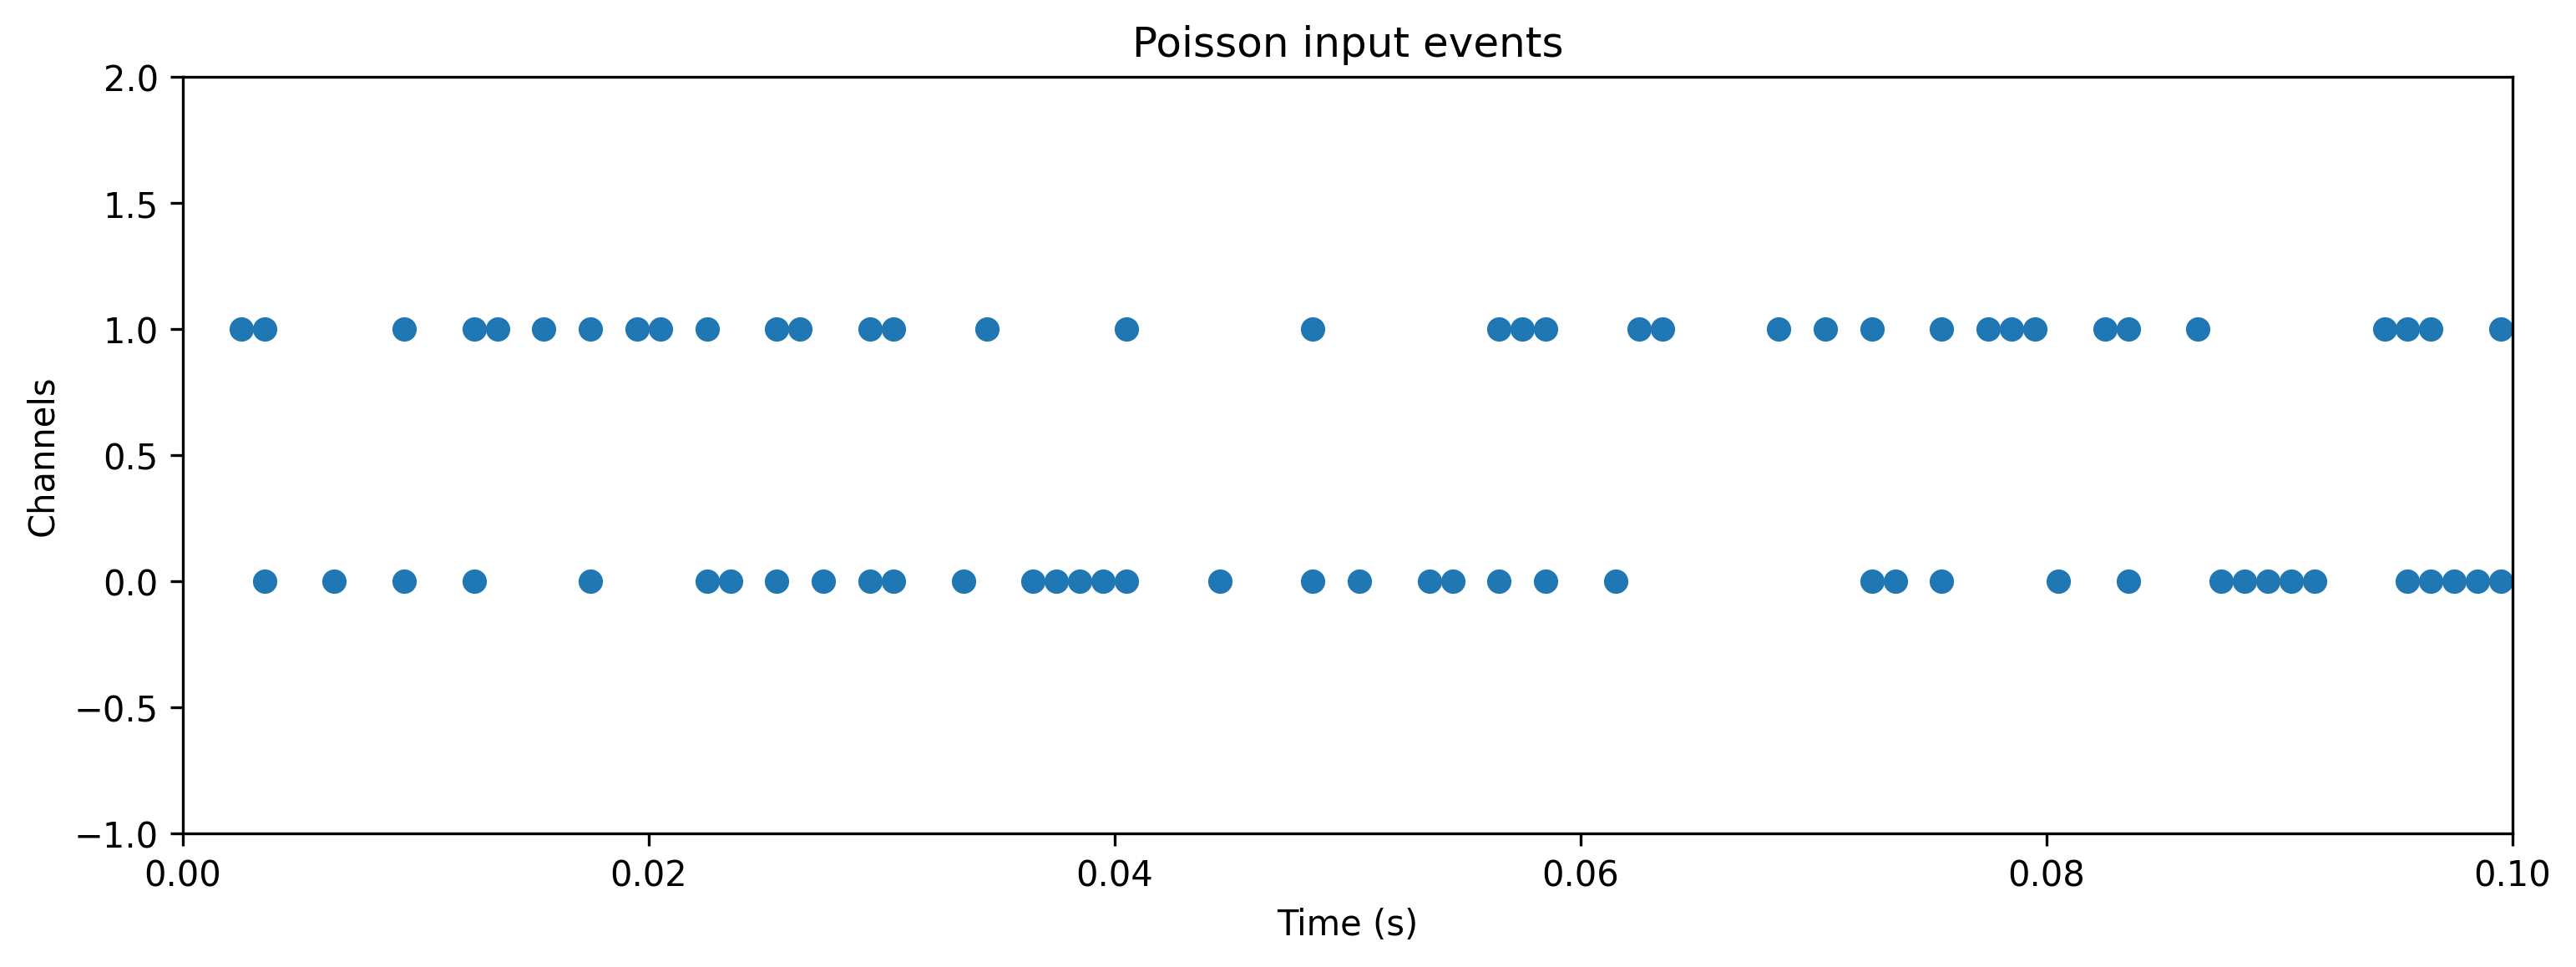

In [12]:
# - Generate some Poisson input
T = 100
f = 0.4
input_spikes = np.random.rand(T, Nin) < f
TSEvent.from_raster(input_spikes, dt, name = 'Poisson input events').plot();

In [13]:
# - Evolve the network on the Xylo HDK via fake auto mode
if found_xylo:
    modSamna.reset_state()
    out, _, r_d = modSamna.evolve(input_spikes.astype(int), record = True)
    
    # - Show the internal state variables recorded 
    print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out', 'times'])


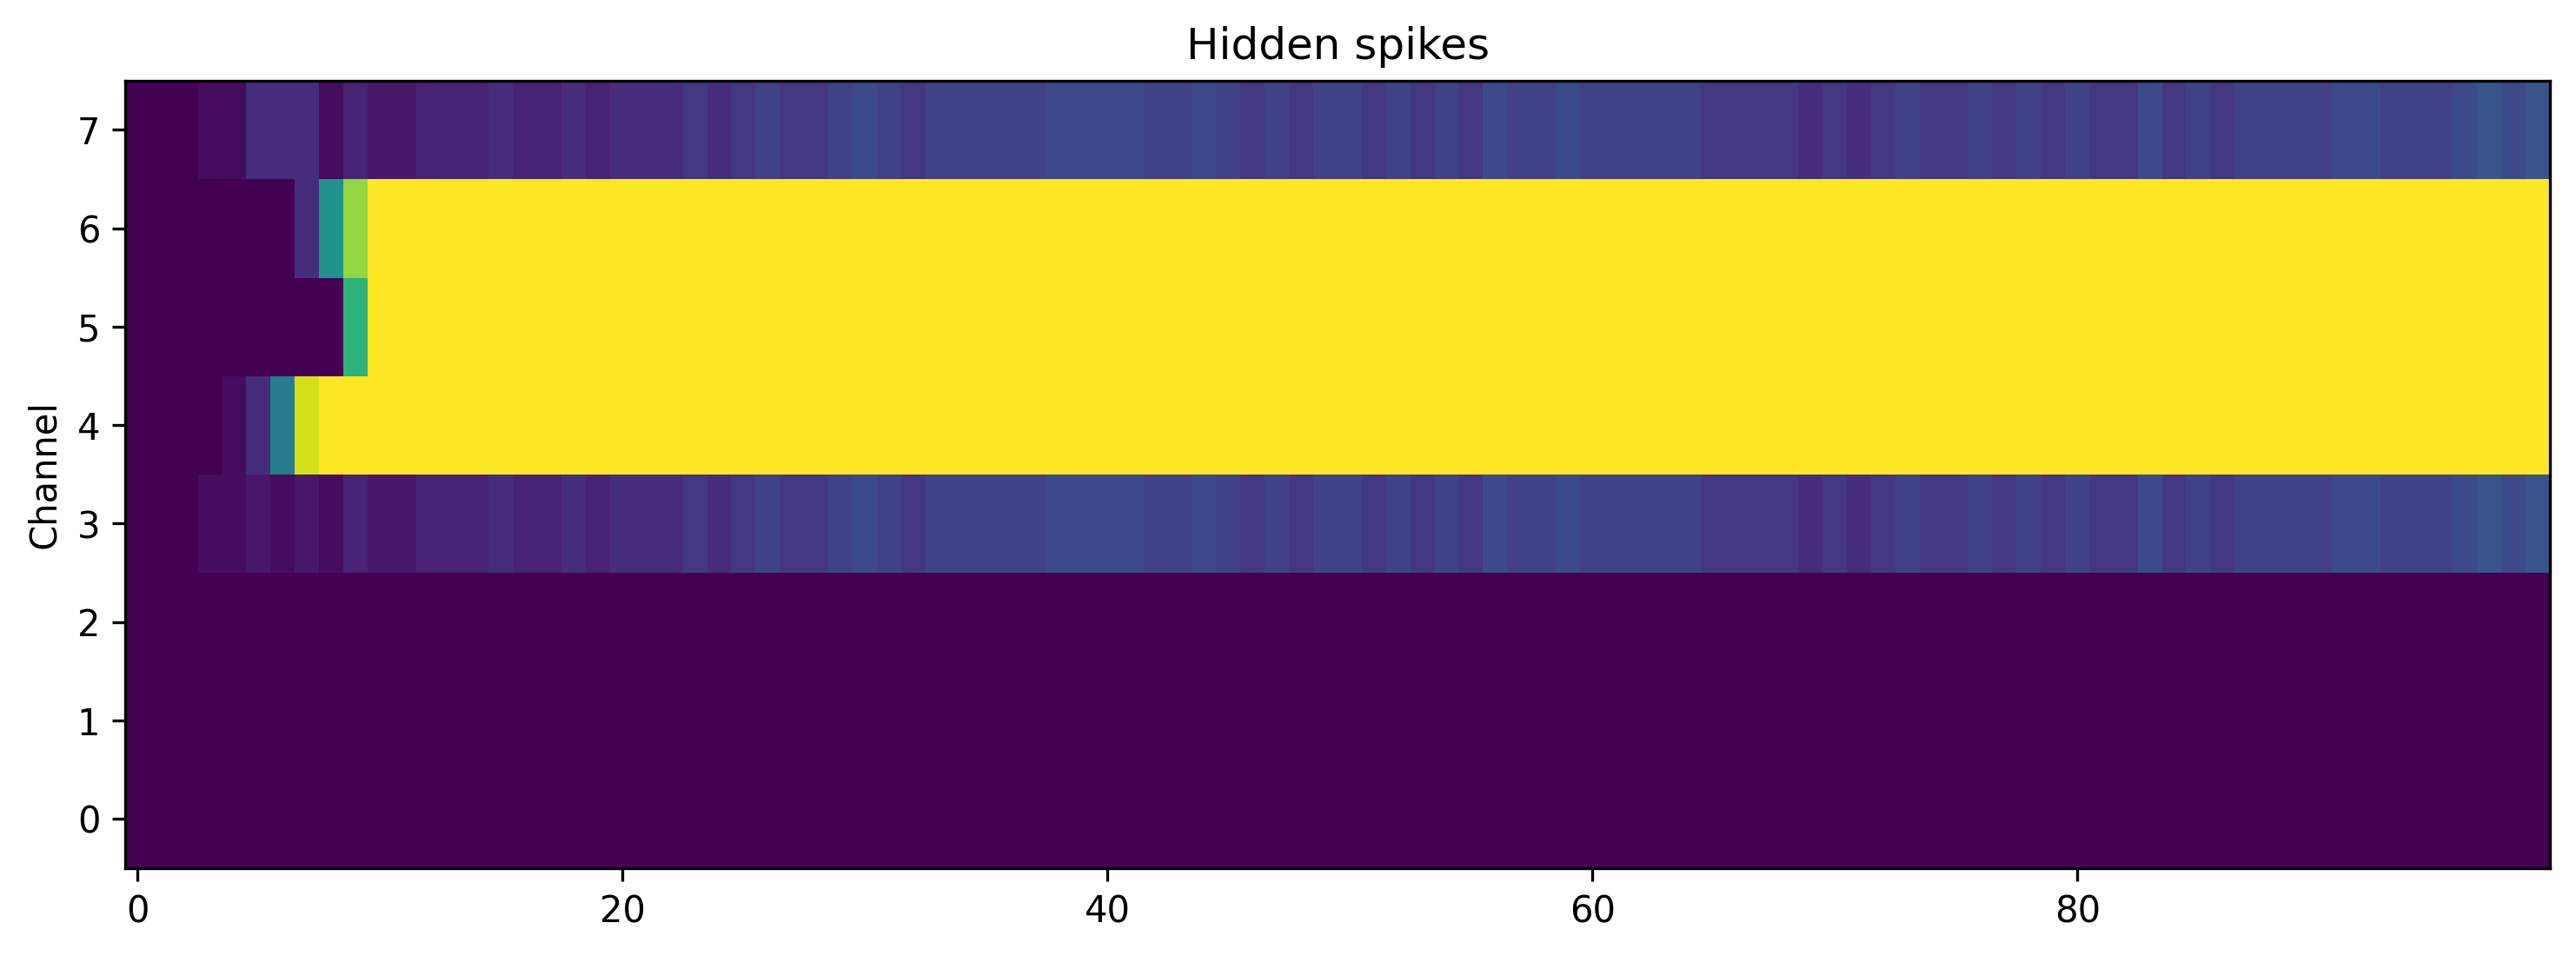

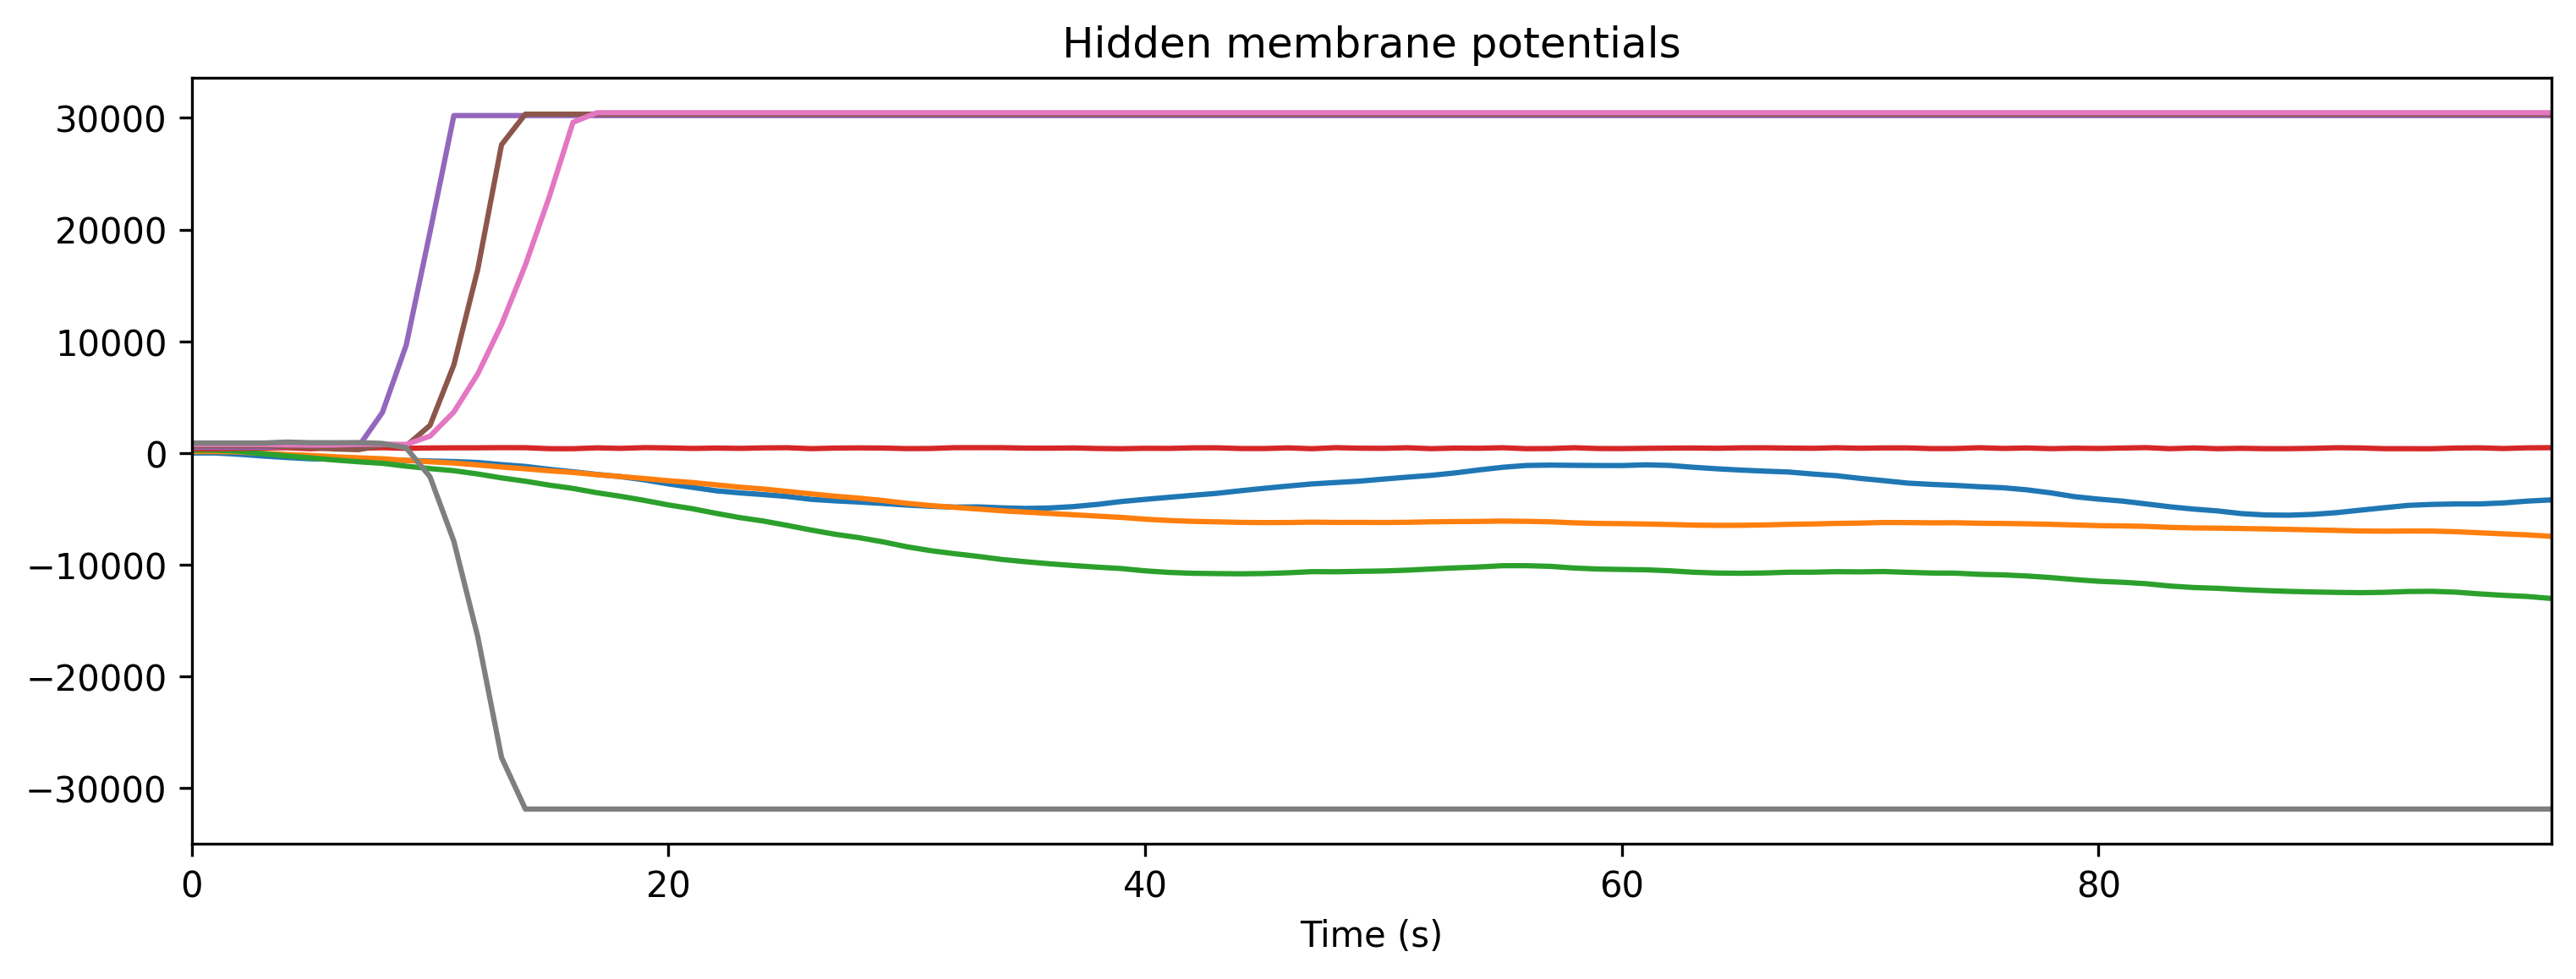

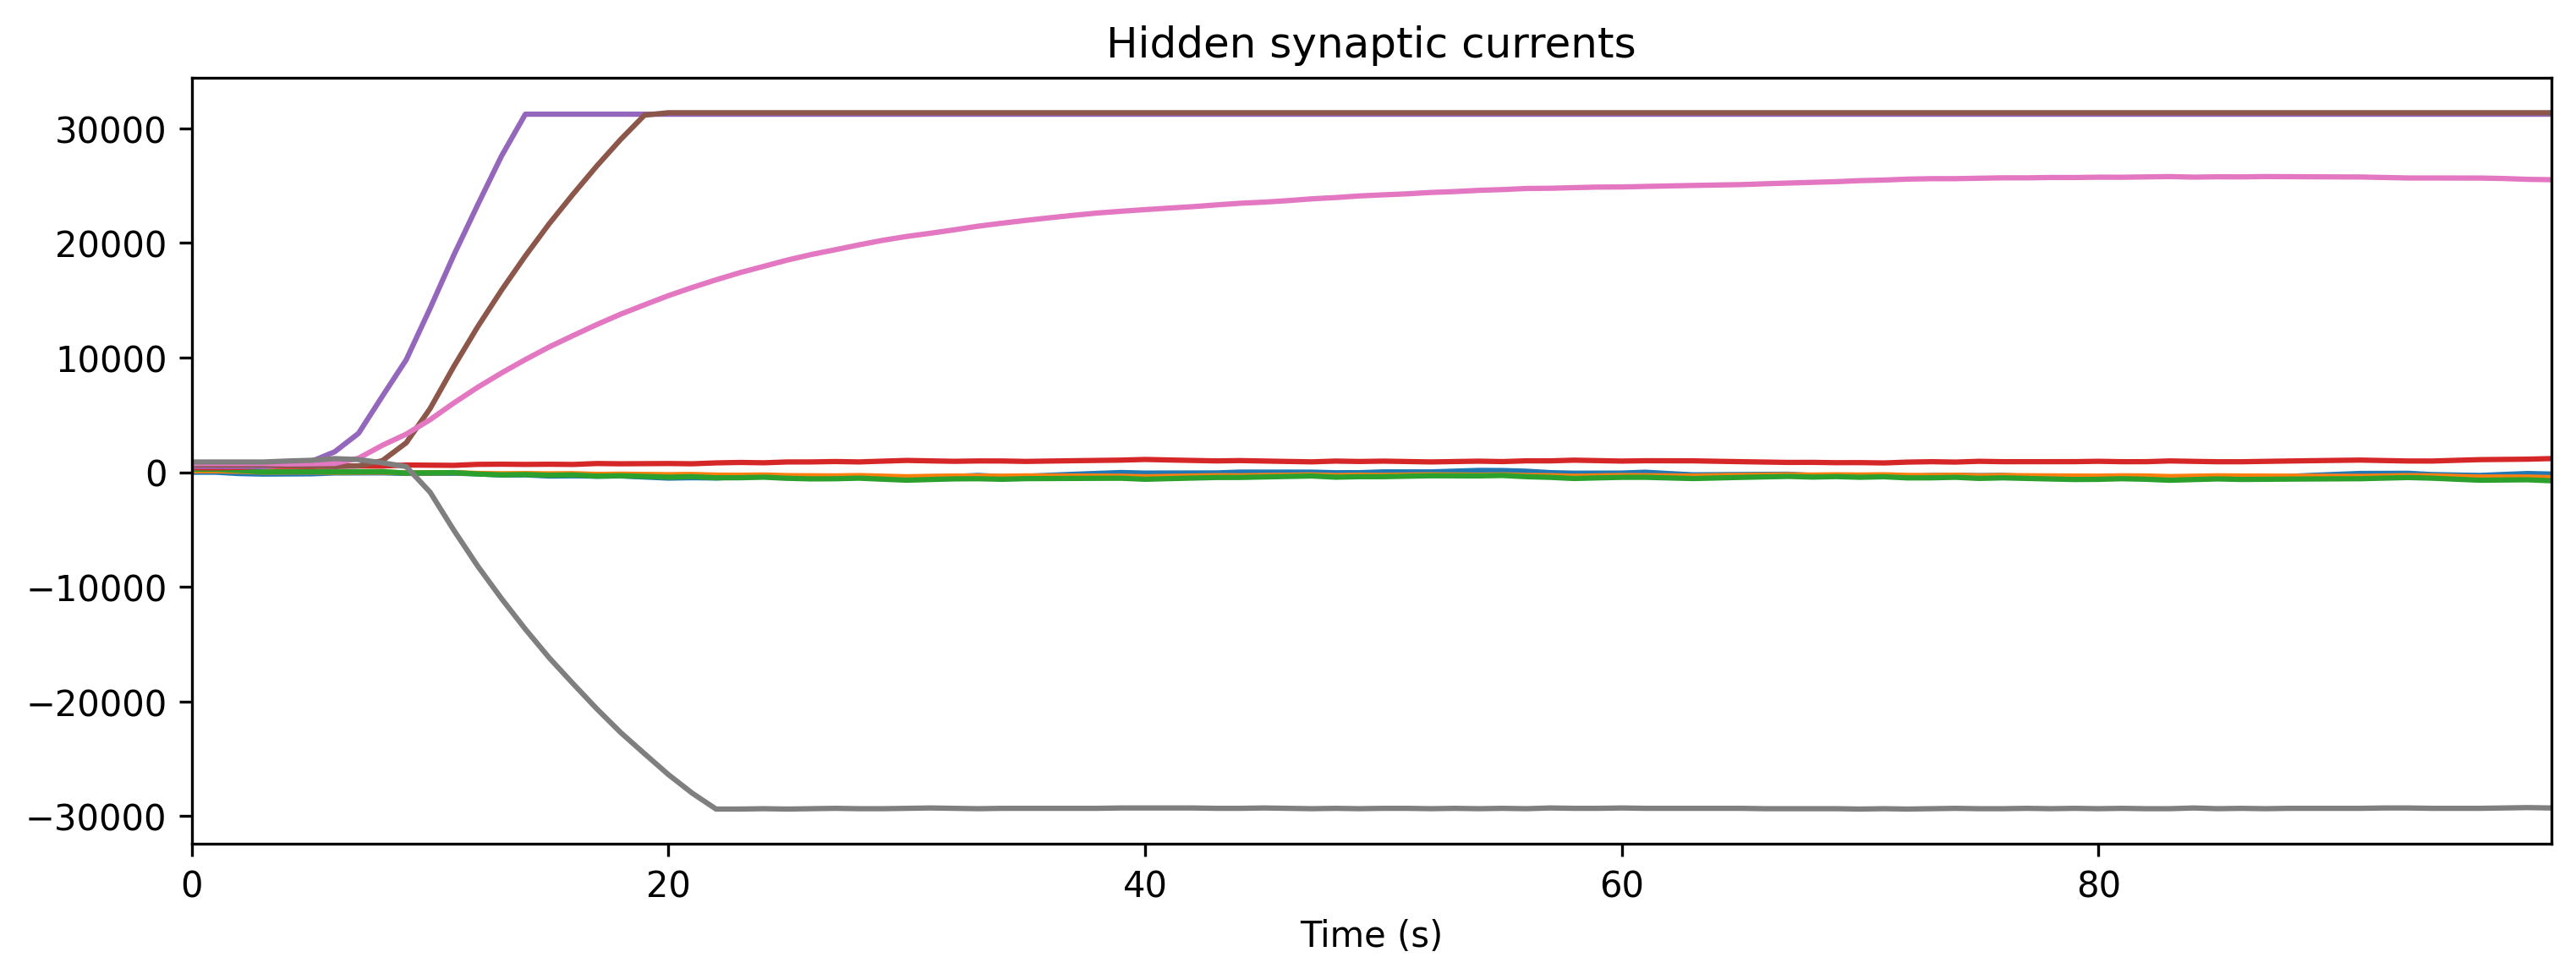

In [14]:
# - Plot some internal state variables
if found_xylo:
    plt.figure()
    plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
    plt.title('Hidden spikes')
    plt.ylabel('Channel')
    
    plt.figure()
    TSContinuous(r_d['times'], r_d['Vmem'], name = 'Hidden membrane potentials').plot(stagger = 127)

    plt.figure()
    TSContinuous(r_d['times'], r_d['Isyn'], name = 'Hidden synaptic currents').plot(stagger = 127)

### Step 3: Simulate the HDK using a bit-precise simulator

In [15]:
# - Use rockpool.devices.xylo.XyloSim
modSim = x.XyloSim.from_config(config, dt=dt)
print(modSim)

XyloSim  with shape (16, 1000, 8)


In [16]:
# - Evolve the input over the network, in simulation
out, _, r_d = modSim(input_spikes, record = True)

# - Show the internal state variables recorded 
print(r_d.keys())

dict_keys(['Vmem', 'Isyn', 'Isyn2', 'Spikes', 'Vmem_out', 'Isyn_out'])


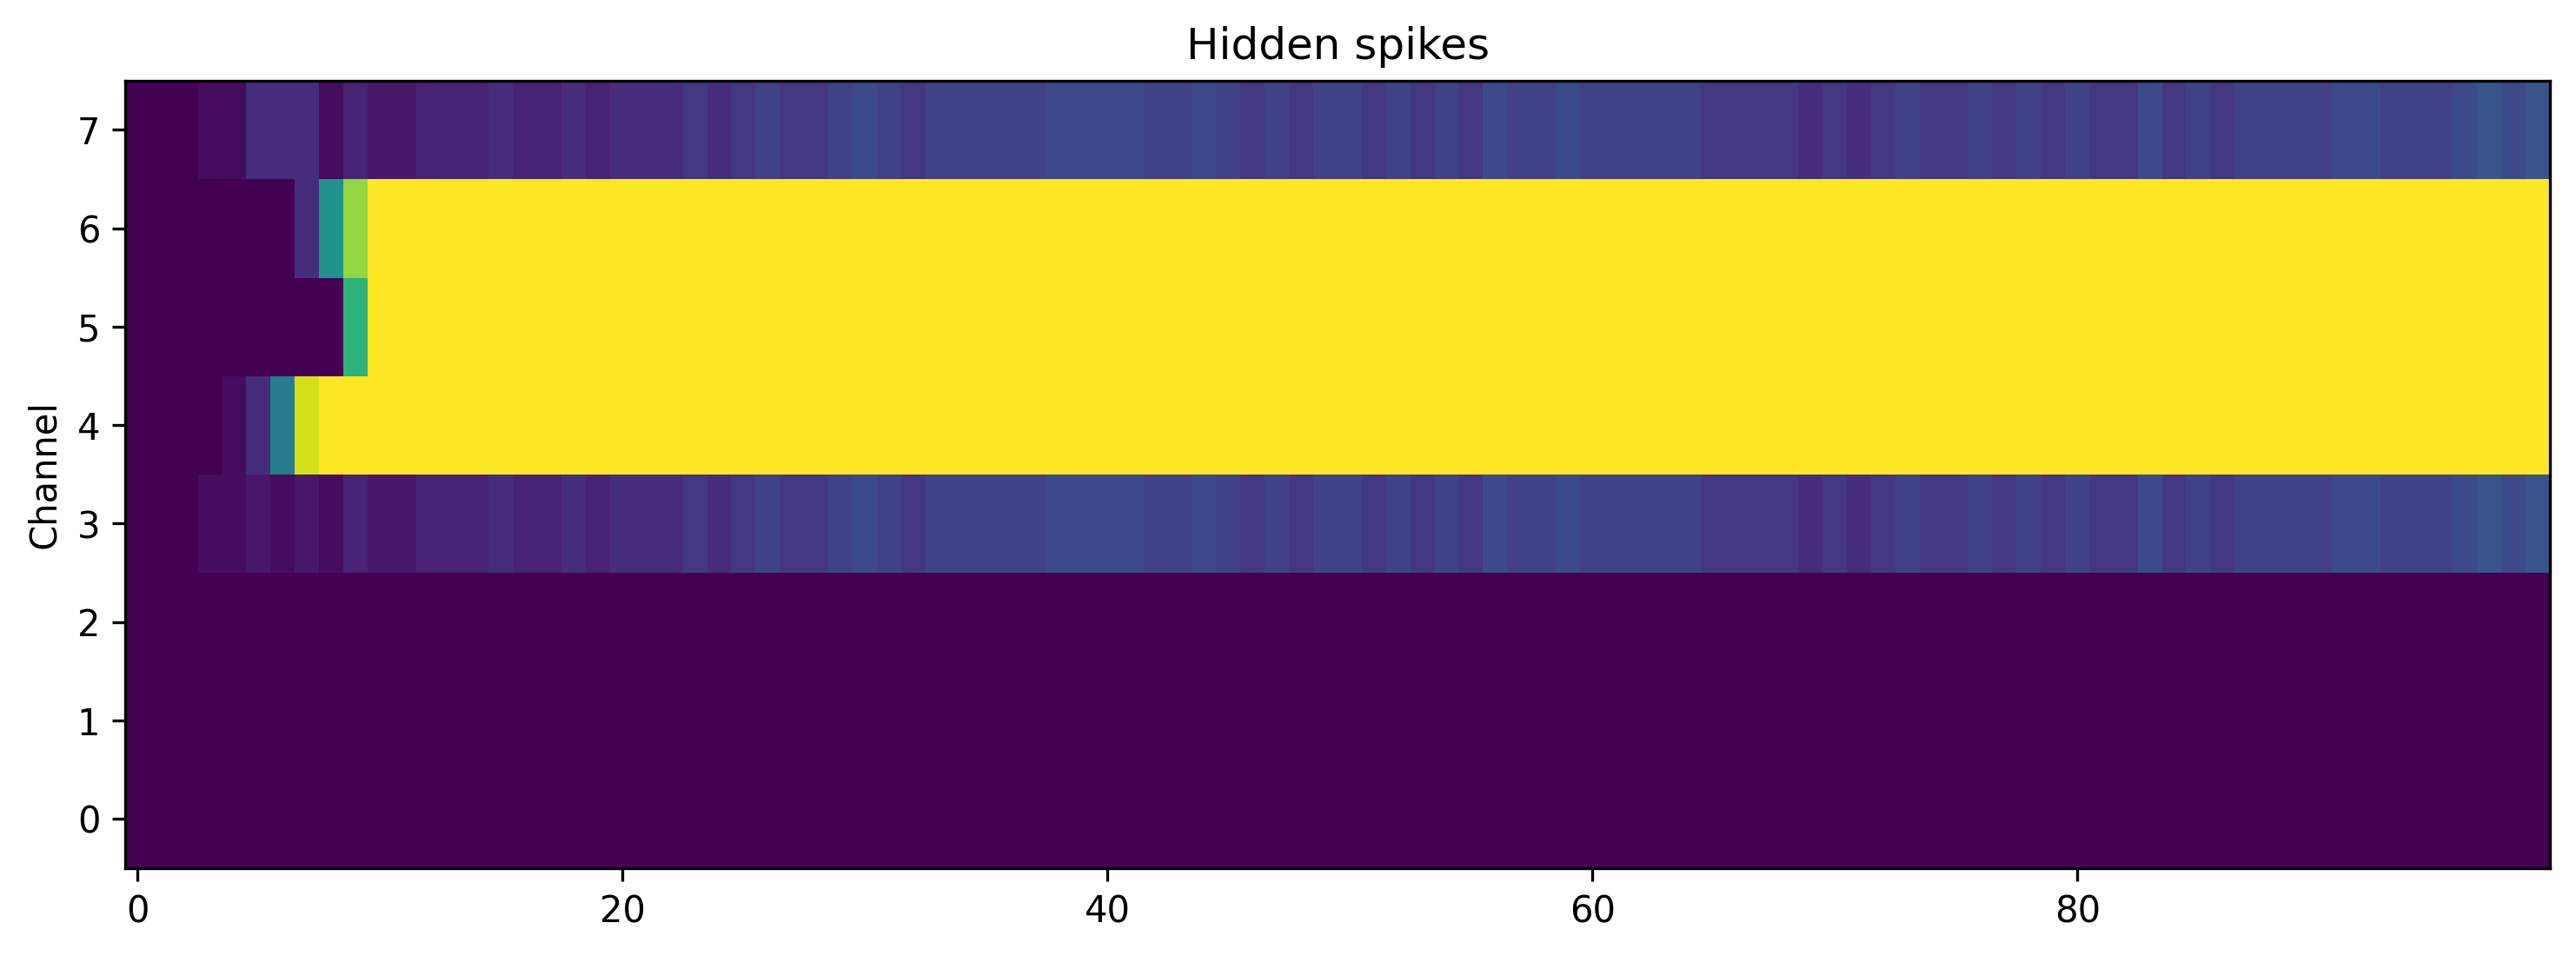

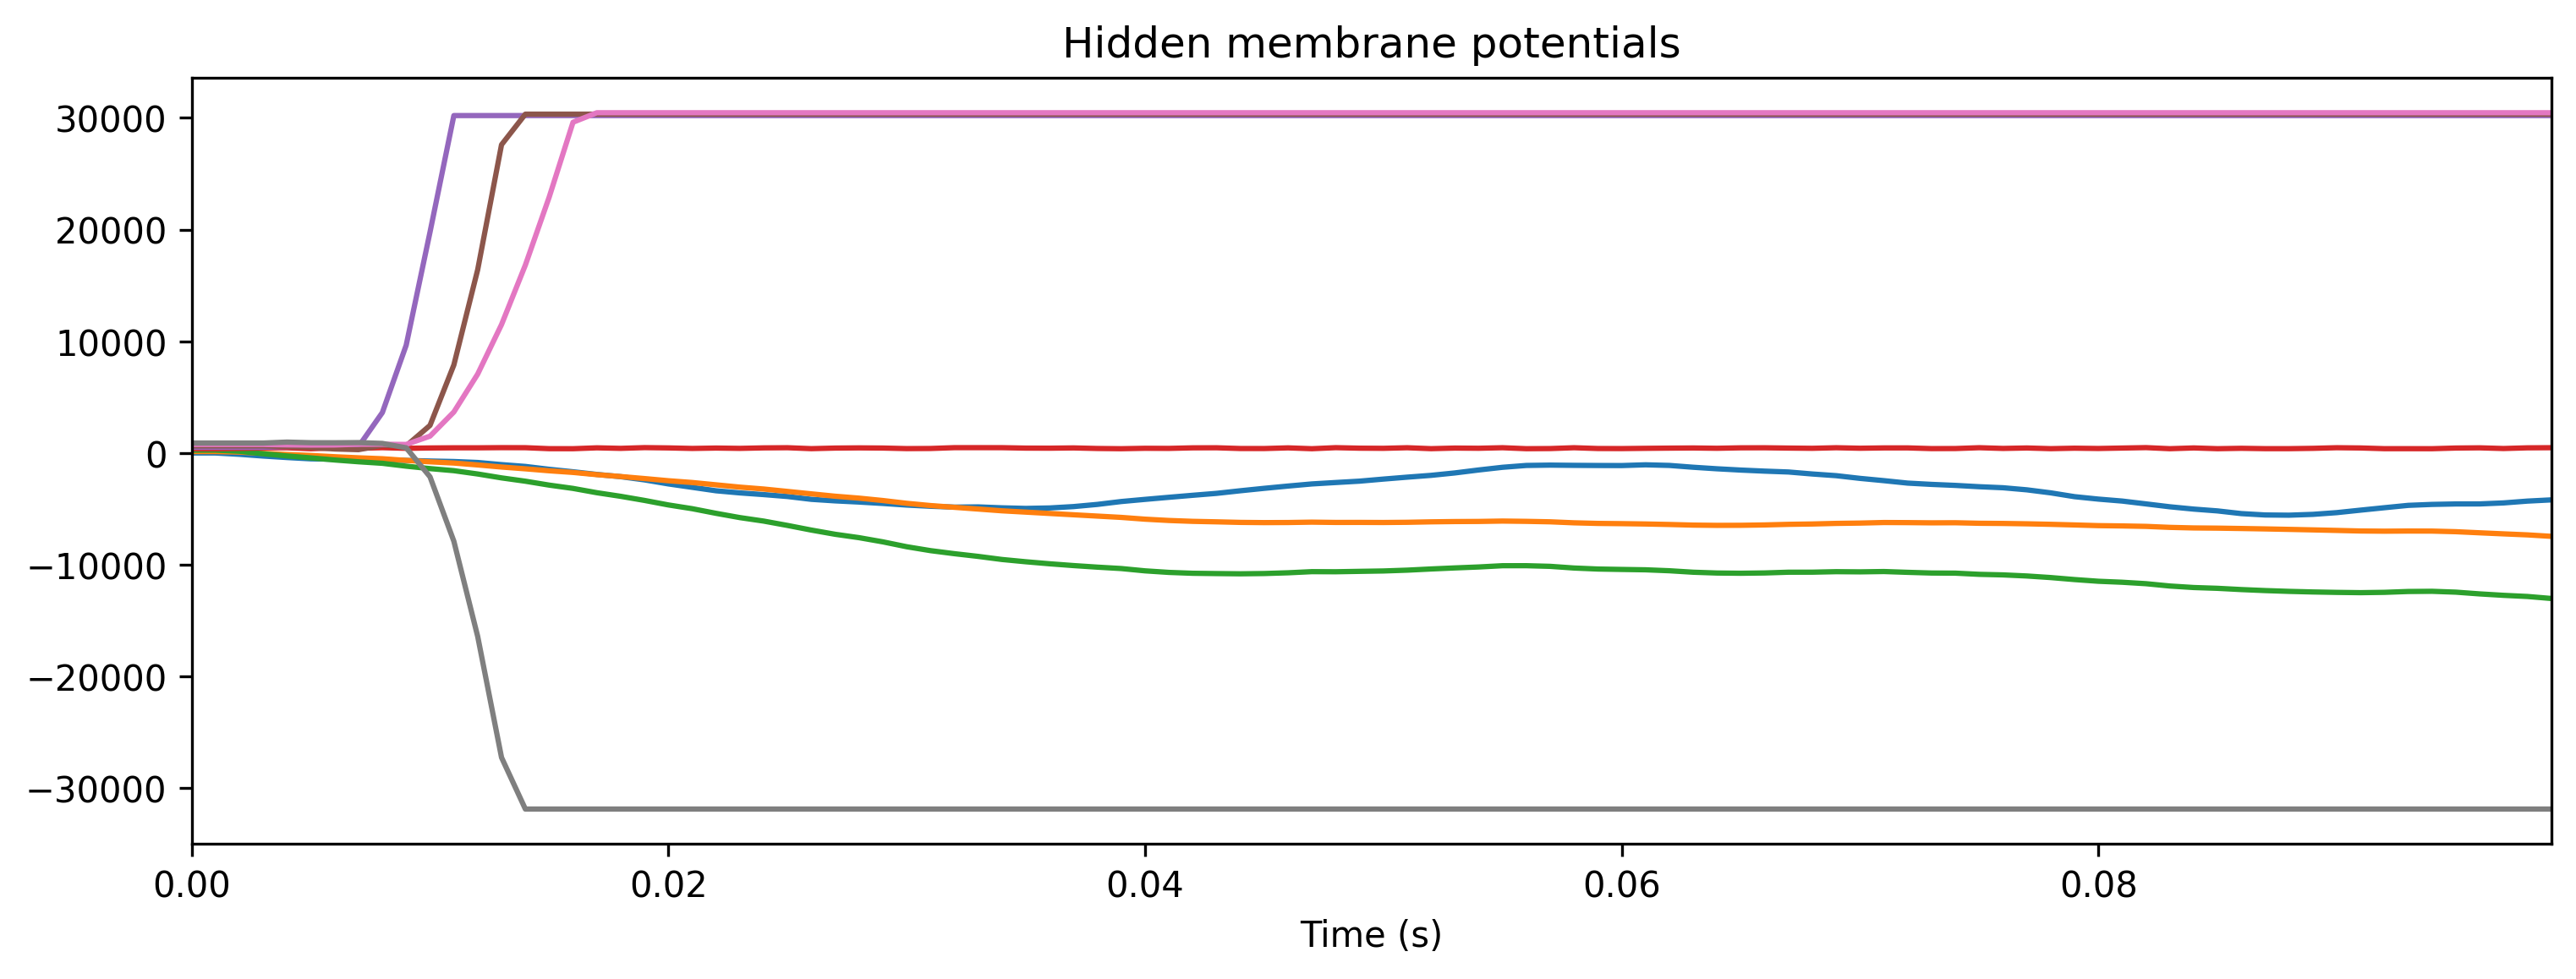

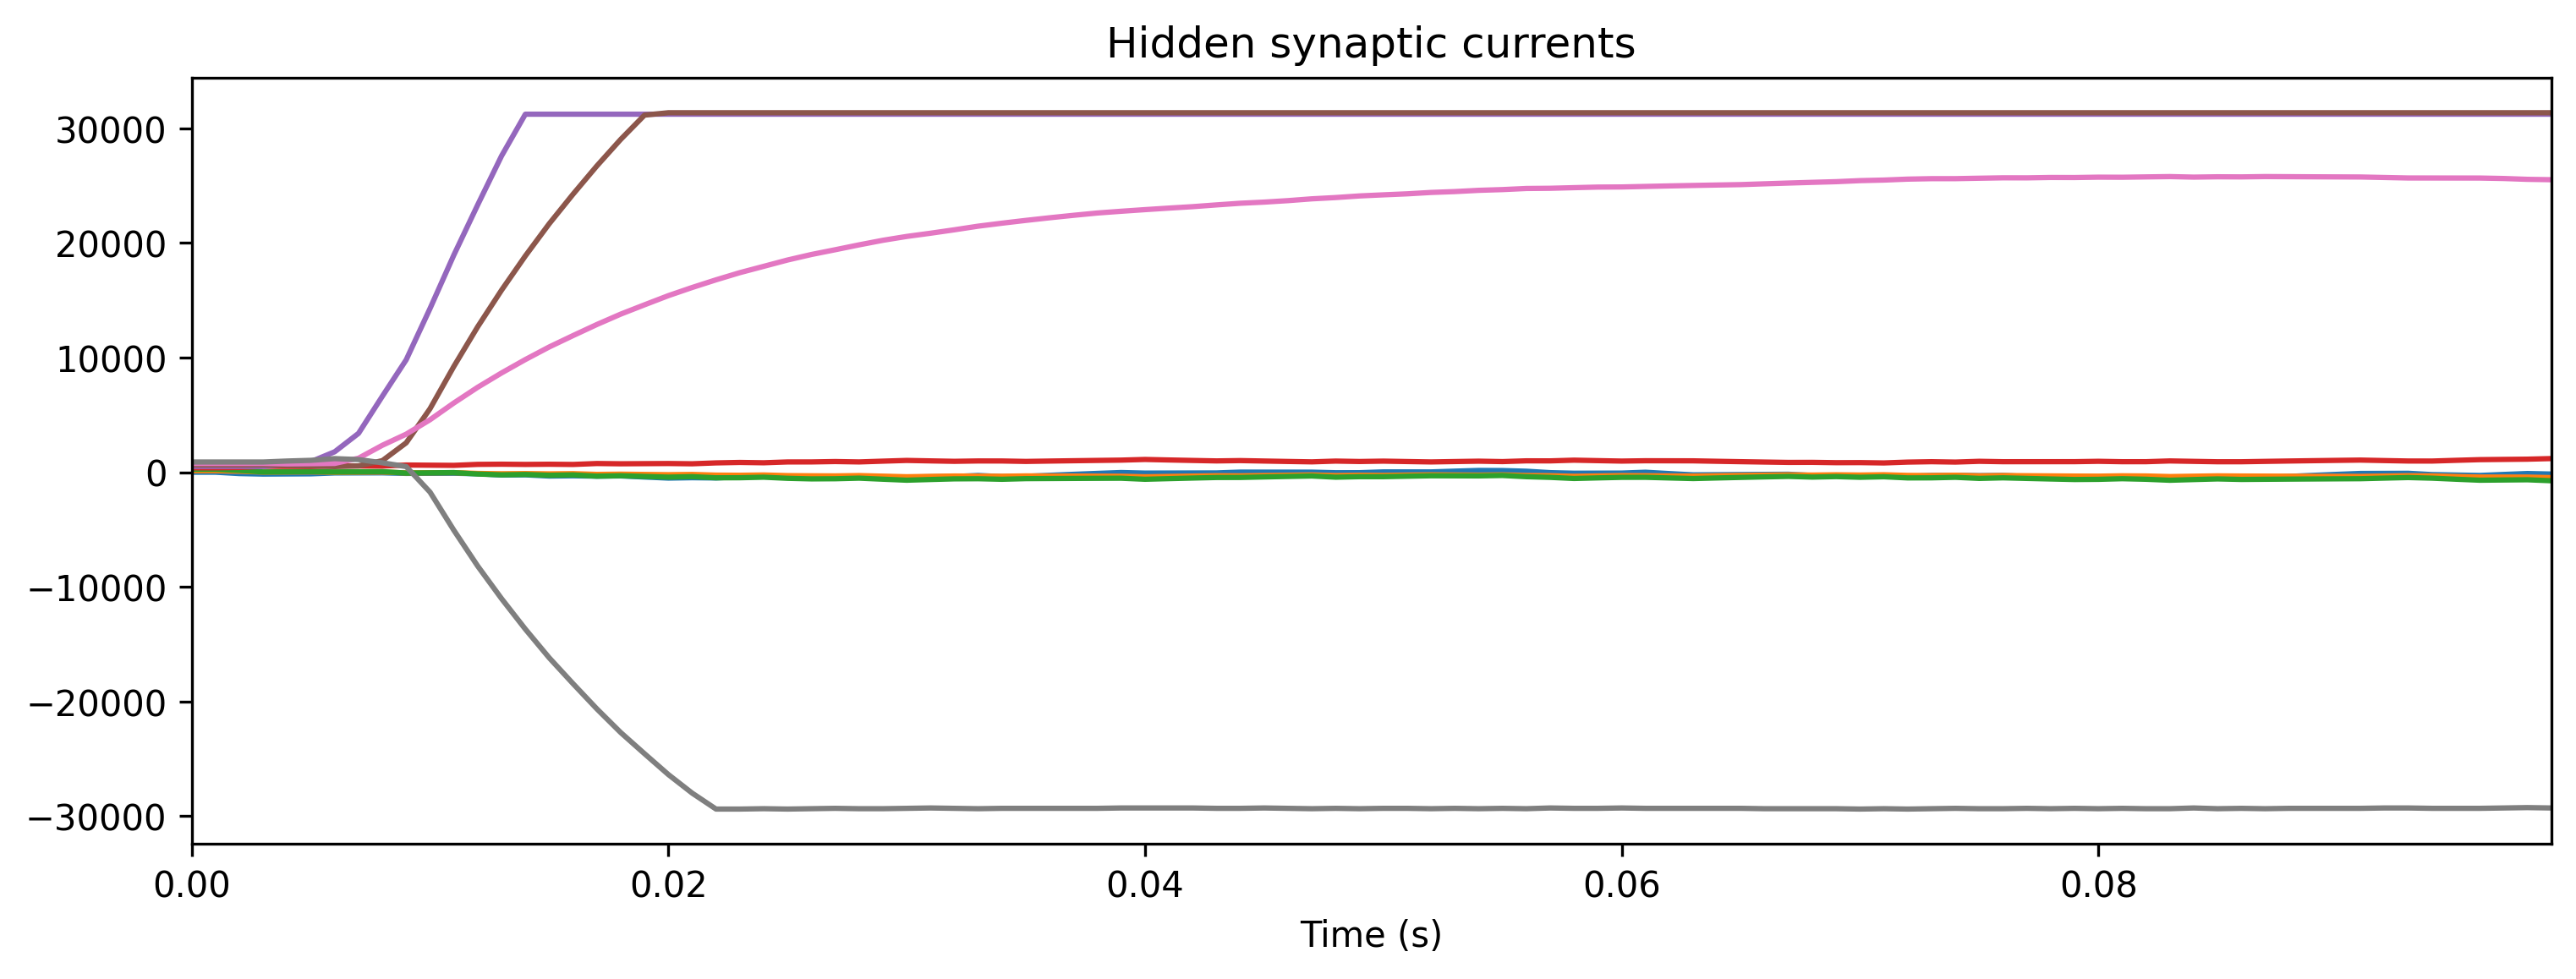

In [17]:
# - Plot some internal state variables
plt.figure()
plt.imshow(r_d['Spikes'].T, aspect = 'auto', origin = 'lower')
plt.title('Hidden spikes')
plt.ylabel('Channel')

plt.figure()
TSContinuous.from_clocked(r_d['Vmem'], dt, name = 'Hidden membrane potentials').plot(stagger = 127)

plt.figure()
TSContinuous.from_clocked(r_d['Isyn'], dt, name = 'Hidden synaptic currents').plot(stagger = 127);

## Part II: Using the Xylo-Audio v2 audio front-end interface


The AFE (Analog Front-End) is used to preprocess single-channel audio signals and convert them into spikes. Here the audio signal is input to the AFE by a microphone mounted on teh hardware dev kit. The AFE has 16 output channels, and you can adjust its parameters via hyperparameters in the :py:class:`.AFESamna` class.

:py:class:`.AFESamna` allows to to access the audio front-end on the dev kit, and record encoded audio either from the on-board microphone or analog audio injected to the dev kit.

:py:class:`.AFESamna` also allows a custom config input which is without auto-calibration. If you do not provide a custom config, we highly suggest you set ``auto_calibrate = True`` on instantiation, which helps to mitigate the effects of background and mechanical noise.

In [19]:
# - Find a xylo A2 HDK.
# - Remember that you always need to **restart** the board before running following lines
xylo_hdk_nodes = xu.find_xylo_a2_boards()
print(xylo_hdk_nodes)

found_xylo = len(xylo_hdk_nodes) > 0

if not found_xylo:
    print('This tutorial requires a connected Xylo HDK to demonstrate.')
else:
    db = xylo_hdk_nodes[0]

In [1]:
# - Set the time resolution and duration to record encoded audio
dt = 1e-2
timesteps = 1000

In [21]:
# - Create an AFESamna module, which wraps the AFE on the Xylo A2
mod = x.AFESamna(db, None, dt=dt, auto_calibrate=True, amplify_level='low', hibernation_mode=False)
print(mod)

# - Evolve the module to record encoded real-time audio as events
spikes_ts, _, _ = mod(np.zeros([0, timesteps, 0]))

Configuring AFE...
Configured AFE
AFESamna  with shape (0, 16)


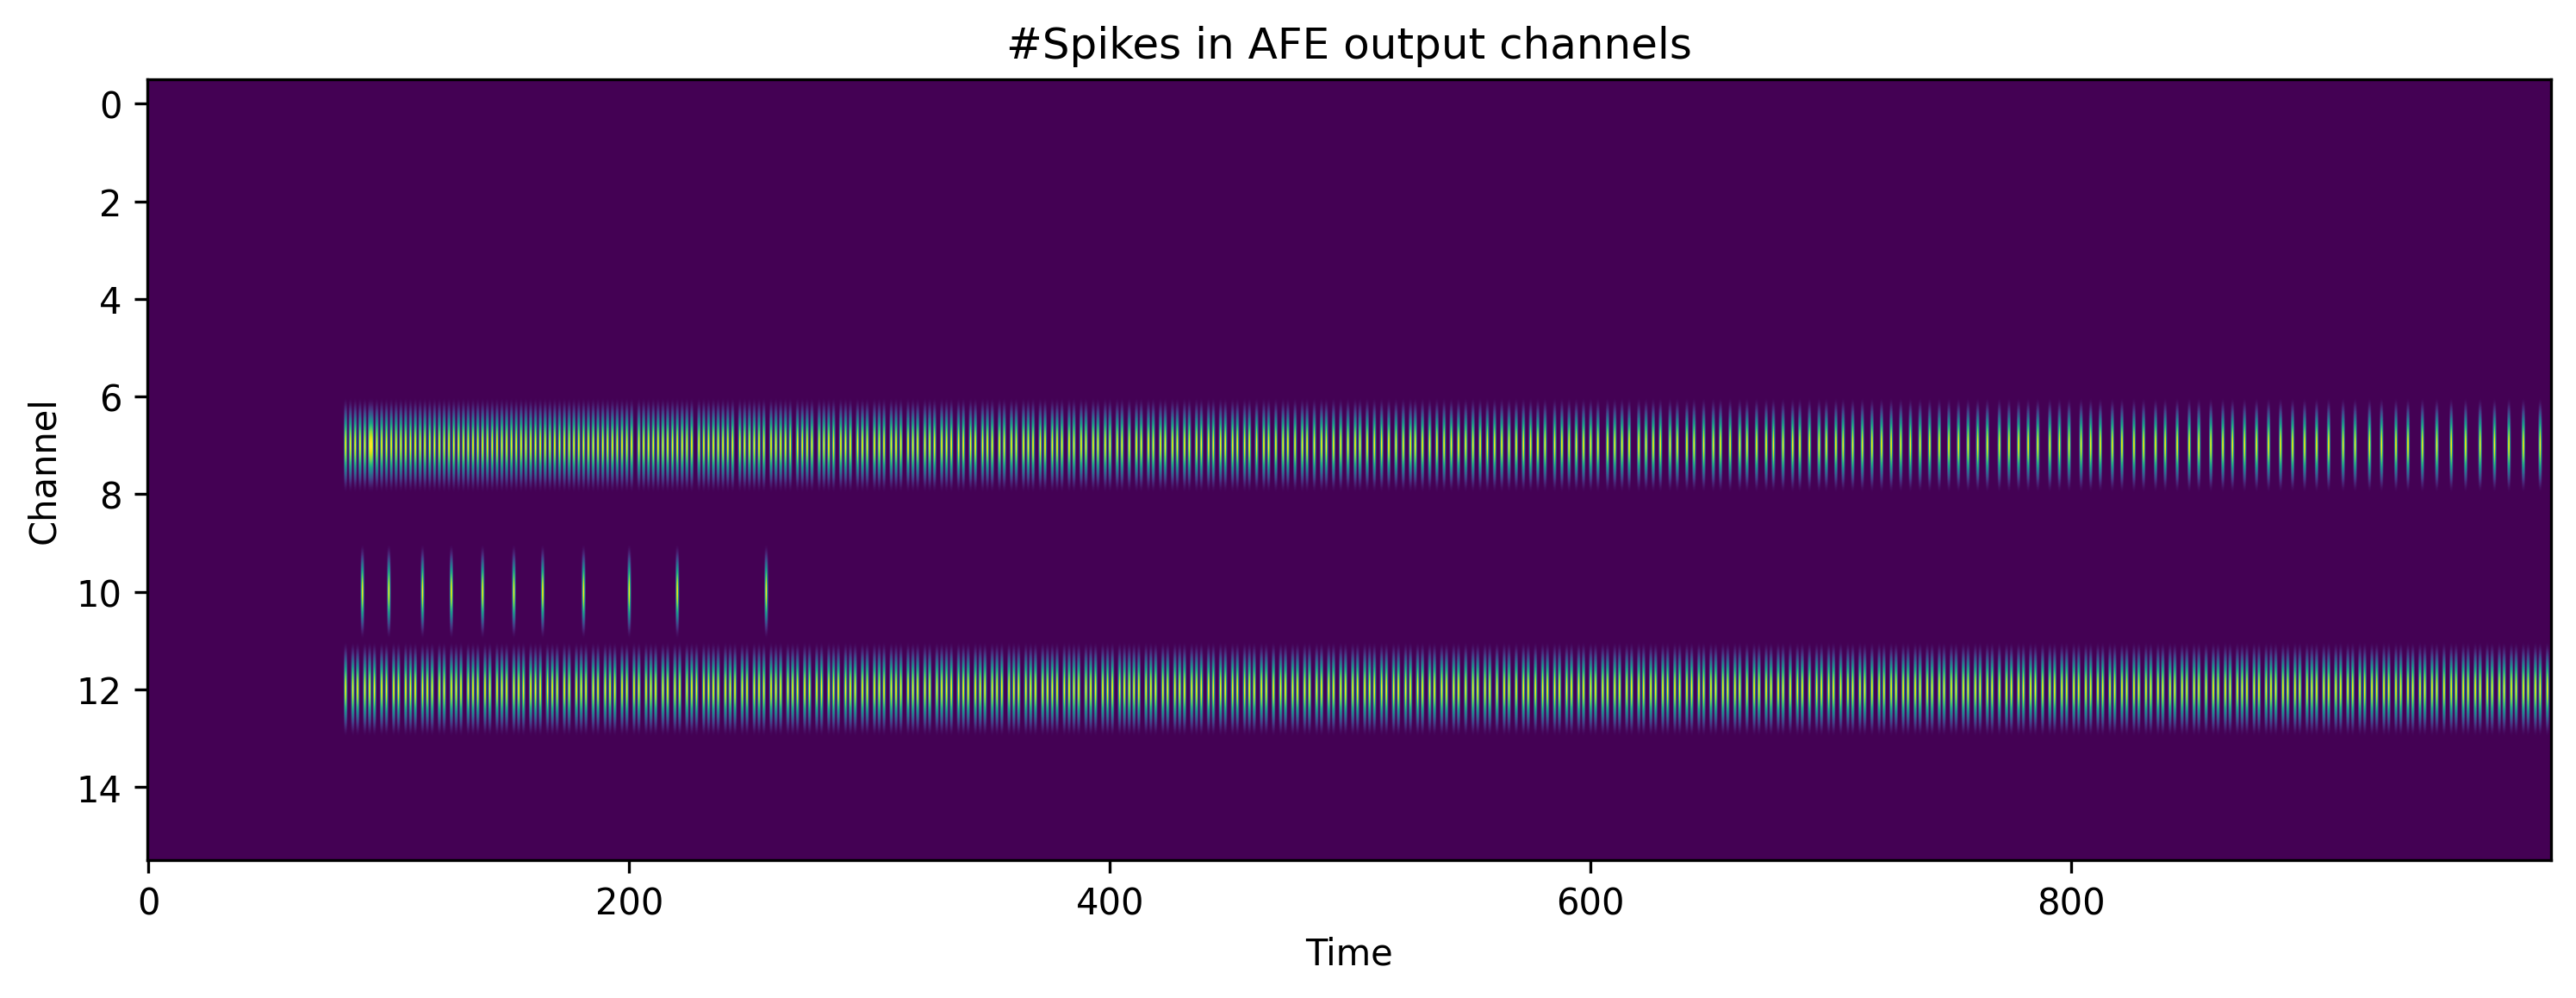

In [22]:
# - Plot the encoded audio events recorded from the AFE
plt.imshow(spikes_ts.T, aspect='auto', interpolation='none')
plt.title('#Spikes in AFE output channels')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.show()


You can get AFE outputs using `AFESamna` class, and feed these outputs to xylo core in fake auto mode. But there is an more efficient way.

## Part III: Using AFE+Xylo core via full auto mode

Full auto mode provides method to preprocess signals and automatically feed processed signals to the chip core, only thing you need to do is read the chip outputs.

In [24]:
# - USe rockpool.devices.xylo.xylo_devkit_utils.find_xylo_a2_boards
# - Please do restart the xylo hdk before running!

xylo_hdk_nodes = xu.find_xylo_a2_boards()
print(xylo_hdk_nodes)

found_xylo = len(xylo_hdk_nodes) > 0

if not found_xylo:
    print('This tutorial requires a connected Xylo HDK to demonstrate.')
else:
    db = xylo_hdk_nodes[0]

In [25]:
# - Use rockpool.devices.xylo.XyloMonitor to deploy to the HDK
# - You need to wait 45s until the AFE auto-calibration is done

output_mode = "Vmem"
amplify_level = "low"
hibernation = False
DN = False
T = 10

modMonitor = x.XyloMonitor(db, config, dt=dt, output_mode=output_mode, amplify_level=amplify_level,
                      hibernation_mode=hibernation, divisive_norm=DN)

Configuring AFE...
Configured AFE


In [26]:
# - A resultList stack to store the results

class ResultList(object):
    def __init__(self, max_len=100):
        self._list = []
        self.max_len = max_len

    def reset(self):
        self._list = []

    def append(self, num):
        if len(self._list) < self.max_len:
            self._list.append(num)
        else:
            self._list[: self.max_len - 1] = self._list[1:]
            self._list[self.max_len - 1] = num

    def is_full(self):
        if len(self._list) == self.max_len:
            return True
        else:
            return False

    def counts(self, features=[]):
        count = 0
        for _ in self._list:
            if _ in features:
                count += 1
        return count

    def __len__(self):
        return len(self._list)

    def print_result(self):
        return self._list



In [27]:
# - Draw a real time image for output channels

lines = [ResultList(max_len=10) for _ in range(Nout)]
time = ResultList(max_len=10)
tt = 0


while True:
    # Process the input signals and evolve on xylo hdk
    output, _, _ = modMonitor.evolve(input_data=np.zeros((T, Nin)))
    if output is not None:
#         print(output)
        output = np.max(output, axis=0)
        for i in range(Nout):
            lines[i].append(output[i])

        time.append(tt)
        tt += 0.1
        ax_time = time.print_result()
        
        for i in range(Nout):
            plt.plot(ax_time, lines[i].print_result(), label=f"class{i}")

        plt.xlabel('time')
        plt.ylabel('Vmem')
        plt.legend()
        plt.pause(0.1)
        display.clear_output(wait=True)
        

KeyboardInterrupt: 

We also provide function to check the version of your input device and return packages accordingly.

In [1]:
from rockpool.devices.xylo.helper import check_version

xylo_hdk_nodes, x = check_version()

The Xylo board version is 2. Importing rockpool.devices.xylo.syns61201 as x 
